In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import lightgbm as lgb
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool
import subprocess
import matplotlib.pyplot as plt
import os
import time
from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold
from features import get_features
from features import encode_label
from features import encode_mean_k_fold
from features import encode_frequency

from report import report
from report import get_feature_importance
from report import submit_to_kaggle
import operator
from tqdm import tqdm
import seaborn as sns
import pprint as pp
from itertools import combinations


def drop_cols(df, cols):
    drop_cols = [c for c in df.columns if c in cols]
    df.drop(drop_cols, axis=1, inplace=True)
    return df


def print_corr(df_corr, keyword=None):
    sns.heatmap(
        df_corr,
        annot=True,
        xticklabels=df_corr.columns.values,
        yticklabels=df_corr.columns.values)

    corr_dict = {}
    for c in list(combinations(df_corr.columns, 2)):
        corr_dict[c] = df_corr.loc[c[0], c[1]]

    corr_list = []
    for i, corr in enumerate(
            sorted(
                corr_dict.items(), key=operator.itemgetter(1), reverse=True)):
        if keyword:
            if keyword in corr:
                corr_list.append("{} {}".format(i, corr))
            else:
                pass
        else:
            corr_list.append("{} {}".format(i, corr))
    pp.pprint(corr_list)
    return corr_list


def compare_corr(df_train, df_test):
    df_train_corr = df_train.corr()
    df_test_corr = df_test.corr()

    corr_dict_train = {}
    corr_dict_test = {}
    corr_dict = {}
    for c in list(combinations(df_train_corr.columns, 2)):
        corr_dict_train[c] = df_train_corr.loc[c[0], c[1]]
        corr_dict_test[c] = df_test_corr.loc[c[0], c[1]]
        corr_dict[c] = abs(corr_dict_train[c] - corr_dict_test[c])

    return corr_dict, corr_dict_train, corr_dict_test

def dict_to_sortedlist(d):
    l = []
    for i, row in enumerate(
            sorted(
                d.items(), key=operator.itemgetter(1), reverse=True)):
        l.append("{} {}".format(i, row))
    return l

/Users/hyundai/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Load pickle

In [2]:
%%time
df_train = pd.read_pickle("input/train_lv01.pickle")
df_test = pd.read_pickle("input/test_lv01.pickle")

train_size = df_train.shape[0]
target_col = 'totals_transactionRevenue'
df_train[target_col].fillna(0.0, inplace=True)
df_train[target_col] = df_train[target_col].astype(float)


# Drop cols nunique < 2
del_cols = ['totals_bounces', 'totals_newVisits', 'visitId']
df_train = drop_cols(df_train, del_cols)
df_test = drop_cols(df_test, del_cols)

CPU times: user 7.19 s, sys: 1.68 s, total: 8.87 s
Wall time: 7.62 s


#### Corr df_train

In [ ]:
_ = print_corr(df_train.corr())

In [ ]:
_ = print_corr(df_train[df_train[target_col] > 0].corr())

In [ ]:
_ = print_corr(df_train[df_train[target_col] == 0].corr())

#### Corr df_test

In [ ]:
_ = print_corr(df_test.corr())

### DEV

#### trafficSource_medium

,trafficSource_medium,totals_hits
0,(none),4.928614
1,(not set),4.400000
2,affiliate,3.405475
3,cpc,6.499961
4,cpm,6.667199
5,organic,4.928795
6,referral,3.944231


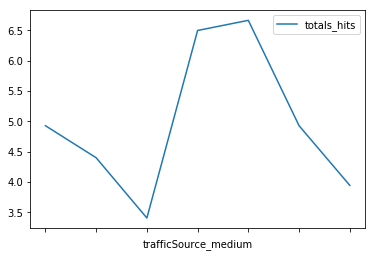

In [3]:
df_g = df_train.groupby(['trafficSource_medium'])['totals_hits'].mean().reset_index()
df_g.plot(x='trafficSource_medium')
df_g

,trafficSource_medium,totals_hits
0,(none),4.071541
1,(not set),1.764706
2,affiliate,3.477108
3,cpc,2.534803
4,cpm,5.960329
5,organic,4.505722
6,referral,4.423155


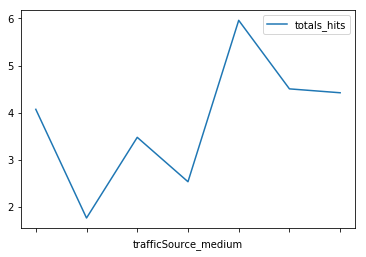

In [4]:
df_g = df_test.groupby(['trafficSource_medium'])['totals_hits'].mean().reset_index()
df_g.plot(x='trafficSource_medium')
df_g

#### *_hits_per_day

In [ ]:
df_g = df_train.groupby(['day'])['totals_hits'].sum().reset_index()
df_g.plot()
df_g

In [ ]:
df_g = df_test.groupby(['day'])['totals_hits'].sum().reset_index()
df_g.plot()
df_g

#### Freq

In [ ]:
corr_cols = [c for c in df_train_X if '_Fre' in c]
corr_cols

In [ ]:
df_test['channelGrouping_Frequency'].plot()


#### Compare corr between train and test

In [ ]:
corr_cols = [c for c in df_train_X if '_Fre' in c]
corr_dict, corr_train, corr_test = compare_corr(df_train[corr_cols], df_test[corr_cols])
pp.pprint(corr_dict)
pp.pprint(corr_train)
pp.pprint(corr_test)

In [ ]:
dict_to_sortedlist(corr_dict)

In [ ]:
df_train['trafficSource_adwordsClickInfo.isVideoAd'].value_counts()

### Feature Engineering

In [5]:
%%time
df_train, fea_cols = get_features(df_train)
df_test, fea_cols = get_features(df_test)
df_train[target_col] = np.log1p(df_train[target_col])

'fea_date_time'  16447.63 ms
'fea_format'  103.12 ms
'fea_device'  2195.12 ms
'fea_totals'  1930.79 ms
'fea_geo_network'  392.59 ms
'fea_traffic_source'  2568.23 ms
'fea_date_time'  14172.53 ms
'fea_format'  93.61 ms
'fea_device'  1987.77 ms
'fea_totals'  1709.75 ms
'fea_geo_network'  341.45 ms
'fea_traffic_source'  2256.90 ms
CPU times: user 1min 5s, sys: 7.02 s, total: 1min 12s
Wall time: 44.2 s


In [ ]:
fea_cols

#### corr df_train and df_test

In [ ]:
_ = print_corr(df_train.corr())

In [ ]:
_ = print_corr(df_test.corr())

#### ttest between df_train and df_test

In [ ]:
# from scipy.stats import ttest_ind
# c = 'browser_category'
# print(c, ttest_ind(df_train[c], df_test[c], equal_var=False))

# for c in fea_cols:
#     print(c, ttest_ind(df_train[c], df_test[c], equal_var=False))

### Encodings

In [6]:
not_used_cols = [
    "date",
    "fullVisitorId",
    "sessionId",
    "visitId",
    'trafficSource_campaignCode',
    target_col,
    #     "visitNumber",
    #     "visitStartTime",
    #     'trafficSource_referralPath',
]

categorical_feature = df_train.select_dtypes(include='object').columns
categorical_feature = [
    c for c in categorical_feature if c not in not_used_cols
]
df_train[categorical_feature].fillna('NA_NULL', inplace=True)
df_test[categorical_feature].fillna('NA_NULL', inplace=True)

len(categorical_feature)

/Users/hyundai/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


28

#### Label Encoding

In [7]:
df_train, df_test = encode_label(df_train, df_test, categorical_feature)

['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'browser_category', 'browser_operatingSystem', 'source_country', 'campaign_medium']


100%|██████████| 28/28 [00:42<00:00,  1.15s/it]

'encode_label'  45530.40 ms


#### Freq Encoding

In [8]:
df_train, df_test = encode_frequency(df_train, df_test, categorical_feature)

100%|██████████| 28/28 [00:26<00:00,  1.04it/s]

(903653, 87) (804684, 86)
'encode_frequency'  27017.84 ms


#### Mean Encoding

In [9]:
df_train, df_test = encode_mean_k_fold(df_train, df_test, categorical_feature, target_col)

100%|██████████| 28/28 [01:28<00:00,  3.49s/it]

(903653, 115) (804684, 114)
Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem',
       ...
       'mean_k_fold_trafficSource_campaign',
       'mean_k_fold_trafficSource_isTrueDirect',
       'mean_k_fold_trafficSource_keyword', 'mean_k_fold_trafficSource_medium',
       'mean_k_fold_trafficSource_referralPath',
       'mean_k_fold_trafficSource_source', 'mean_k_fold_browser_category',
       'mean_k_fold_browser_operatingSystem', 'mean_k_fold_source_country',
       'mean_k_fold_campaign_medium'],
      dtype='object', length=115)
'encode_mean_k_fold'  88880.80 ms


#### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# y_categorized = np.digitize(df_train[target_col], bins=np.arange(2,24,2))
# clf = LinearDiscriminantAnalysis(n_components=10)
# clf.fit(df_train[categorical_feature], y_categorized)

In [ ]:
# df_train_lda = pd.DataFrame(clf.transform(df_train[categorical_feature]))
# df_test_lda = pd.DataFrame(clf.transform(df_test[categorical_feature]))

# col_map={i:'lda_{}'.format(i) for i in range(10)}
# df_train_lda.rename(columns=col_map, inplace=True)
# df_test.rename(columns=col_map, inplace=True)

# df_train = pd.concat([df_train, df_train_lda], axis=1)
# df_test = pd.concat([df_test, df_test_lda], axis=1)                

#### LDA with Total_hit

In [ ]:
df_train['totals_hits'].hist()

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



clf = LinearDiscriminantAnalysis(n_components=10)
df_merge = pd.concat([df_train[categorical_feature + ['totals_hits']], 
                      df_test[categorical_feature + ['totals_hits']]])

y_categorized = np.digitize(df_merge['totals_hits'], bins=np.arange(0,6,1))

clf.fit(df_merge[categorical_feature], y_categorized)

LinearDiscriminantAnalysis(n_components=10, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [11]:
df_train_lda = pd.DataFrame(clf.transform(df_train[categorical_feature]))
df_test_lda = pd.DataFrame(clf.transform(df_test[categorical_feature]))

col_map={i:'lda_total_hits{}'.format(i) for i in range(10)}
df_train_lda.rename(columns=col_map, inplace=True)
df_test.rename(columns=col_map, inplace=True)

df_train = pd.concat([df_train, df_train_lda], axis=1)
df_test = pd.concat([df_test, df_test_lda], axis=1)                

### Split X and y, Remove not_used_cols

In [12]:
df_train_y = df_train[target_col].astype(float)

df_train_idx = df_train[['fullVisitorId', target_col]]
df_train_X = drop_cols(df_train.copy(), not_used_cols)

df_test_idx = df_test[['fullVisitorId']]
df_test_X = drop_cols(df_test.copy(), not_used_cols)

### Training 531

In [13]:
feature_name = list(df_train_X.columns)
print(feature_name)
prediction_train = np.zeros(df_train_X.shape[0])
prediction = np.zeros(df_test_X.shape[0])

['channelGrouping', 'visitNumber', 'visitStartTime', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_hits', 'totals_pageviews', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'month', 'day', 'hour', 'weekday', 'month_unique_user_count', 'weekday_unique_user_count', 'hour_unique_user_count', 'user_hour_mean', 'user_hour_max', 'user_hour_min', 'browser_category', 'browser_operatingSystem', 'mean_hour_per_browser_operatingSystem', 'source_co

In [14]:
def modeling(fold_col, X_train, X_valid, y_train, y_valid):
    print('X_train:', X_train.shape, 'X_valid:', X_valid.shape, 'Rate:',
          X_valid.shape[0] / X_train.shape[0])
    if X_valid.shape[0] / X_train.shape[0] > 1.0:
        print('No Execution')
        return

    train = lgb.Dataset(
        X_train.values,
        label=y_train.values,
        feature_name=feature_name,
        #         categorical_feature=categorical_feature
    )

    valid = lgb.Dataset(
        X_valid.values,
        label=y_valid.values,
        feature_name=feature_name,
        #         categorical_feature=categorical_feature
    )

    #     params = {
    #         "objective": "regression",
    #         "metric": "rmse",
    #         "max_depth": 8,
    #         "min_child_samples": 20,
    #         "reg_alpha": 1,
    #         "reg_lambda": 1,
    #         "num_leaves": 257,
    #         "learning_rate": 0.01,
    #         "subsample": 0.8,
    #         "colsample_bytree": 0.8,
    #         "subsample_freq ": 5,
    #     }
    #     params = {
    #     "objective": "regression",
    #     "metric": "rmse",
    #     "num_leaves": 30,
    #     "min_child_samples": 100,
    #     "learning_rate": 0.1,
    #     "bagging_fraction": 0.7,
    #     "feature_fraction": 0.5,
    #     "bagging_frequency": 5,
    #     "bagging_seed": 2018,
    #     "verbosity": -1
    # }

    # param = {
    #     "objective": "regression",
    #     "metric": "rmse",
    #     "max_depth": 8,
    #     "min_child_samples": 21,
    #     "reg_alpha": 1,
    #     "reg_lambda": 1,
    #     "num_leaves": 257,
    #     "learning_rate": 0.01,
    #     "subsample": 0.82,
    #     "colsample_bytree": 0.84,
    #     "verbosity": -1
    # }

    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 30,
        "min_child_samples": 100,
        "learning_rate": 0.1,
        "bagging_fraction": 0.7,
        "feature_fraction": 0.5,
        "bagging_frequency": 5,
        "bagging_seed": 1989,
        "verbosity": -1,
        'seed': 1989
    }

    evals_result = {}
    train_params = {
        'params': params,
        'train_set': train,
        'valid_sets': [train, valid],
        'valid_names': ['train', 'valid'],
        'early_stopping_rounds': 300,  #50
        'num_boost_round': 10000,  #500
        'verbose_eval': 25,
        'feval': None,
        'evals_result': evals_result,
        #     'categorical_feature': 'auto',
    }

    model = lgb.train(**train_params)

    global prediction_train, prediction
    print('predict train set')
    pred_train = model.predict(
        df_train_X.values, num_iteration=model.best_iteration)
    prediction_train += pred_train
    df_fold_train = df_train_idx.copy()
    df_fold_train[fold_col] = pred_train

    print('predict test set')
    pred = model.predict(df_test_X.values, num_iteration=model.best_iteration)
    prediction += pred
    df_fold_test = df_test_idx.copy()
    df_fold_test[fold_col] = pred

    # report
    msg = [fold_col, str(df_train_X.columns), str(train_params)]
    submit_file_path = report(df_fold_train, df_fold_test, pred_train, pred,
                              msg, model)
    print(submit_file_path)

    return model

In [15]:
X_train, X_valid = df_train_X[df_train['date'] <= 20170531], df_train_X[df_train['date'] > 20170531]
y_train, y_valid = df_train_y[df_train['date'] <= 20170531], df_train_y[df_train['date'] > 20170531]

model = modeling('once', X_train, X_valid, y_train, y_valid)

X_train: (765707, 116) X_valid: (137946, 116) Rate: 0.18015507237102443
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.63362	valid's rmse: 1.74135
[50]	train's rmse: 1.58545	valid's rmse: 1.70064
[75]	train's rmse: 1.56308	valid's rmse: 1.69365
[100]	train's rmse: 1.54668	valid's rmse: 1.68979
[125]	train's rmse: 1.53197	valid's rmse: 1.68866
[150]	train's rmse: 1.5181	valid's rmse: 1.68656
[175]	train's rmse: 1.50592	valid's rmse: 1.68622
[200]	train's rmse: 1.49393	valid's rmse: 1.68429
[225]	train's rmse: 1.48202	valid's rmse: 1.68261
[250]	train's rmse: 1.47345	valid's rmse: 1.6836
[275]	train's rmse: 1.46538	valid's rmse: 1.68385
[300]	train's rmse: 1.45739	valid's rmse: 1.684
[325]	train's rmse: 1.45041	valid's rmse: 1.68437
[350]	train's rmse: 1.44171	valid's rmse: 1.68437
[375]	train's rmse: 1.43402	valid's rmse: 1.68439
[400]	train's rmse: 1.42664	valid's rmse: 1.68385
[425]	train's rmse: 1.41862	valid's rmse: 1.6836
[450]	train's rmse: 1.4

### Submit

In [16]:
msg = """label / freq / mean / lda hits encode, add fea, remove high corr fea, 531"""
submit_file = 'results/2018-09-29T091912__T1.482_V1.683_R1.683_K/aiden_2018-09-29T091912.csv.tar.gz'
submit_to_kaggle(submit_file, msg)

kaggle competitions submit -c ga-customer-revenue-prediction -f results/2018-09-29T091912__T1.482_V1.683_R1.683_K/aiden_2018-09-29T091912.csv.tar.gz -m "label / freq / mean / lda hits encode, add fea, remove high corr fea, 531"
    


### ETC

In [ ]:
dict_to_sortedlist(corr_dict)

In [ ]:
df_corr = df_train_X[df_train_y > 0].corr()

In [ ]:
df_info = df_corr[(df_corr > 0.8) & (df_corr != 1.0)]


def _print(row, c):
    x = row[c]
    if not np.isnan(x):
        print(c, ':', row.name, x)


#         print(row.name)

for c in df_info.columns:
    df_info.apply(lambda row: _print(row, c), axis=1)

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(df_corr)

In [ ]:
import seaborn as sns
sns.heatmap(df_corr, 
            xticklabels=df_corr.columns.values,
            yticklabels=df_corr.columns.values)

In [ ]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [ ]:
plot_corr(df_train_X)

In [ ]:
df_train[target_col].hist()

In [ ]:
corr_cols = [c for c in df_train_X if '_Fre' in c]
corr_cols

In [ ]:
df_train_X['channelGrouping_Frequency'].value_counts()

In [ ]:
df_test['channelGrouping_Frequency'].value_counts()

In [ ]:
corr_cols = [c for c in df_train_X if 'mean_k_fold_' in c]
corr_cols

In [ ]:
df_train_X['mean_k_fold_channelGrouping'].value_counts()

In [ ]:
df_test['mean_k_fold_channelGrouping'].value_counts()